<a href="https://colab.research.google.com/github/JonMcEntee/ai-text-detection/blob/main/AI_generated_Text_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U transformers accelerate peft huggingface_hub transformers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from umap import UMAP

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate

from sentence_transformers import SentenceTransformer
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers import losses, SentenceTransformer
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import SentenceTransformerTrainingArguments

random_seed = 42

In [2]:
# Mount into drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Introduction

This notebook documents my submission to the [LLM - Detect AI-Generated Text Kaggle competition](https://www.kaggle.com/c/llm-detect-ai-generated-text), which challenges participants to distinguish between human-written and machine-generated text. As large language models (LLMs) become increasingly sophisticated, identifying synthetic text is crucial for maintaining trust in digital content.

# Exploratory Data Analysis

We load in the original dataset given to us by the competition

In [ ]:
train_essays = pd.read_csv("./drive/My Drive/llm-detect-ai-generated-text/train_essays.csv")
train_prompts = pd.read_csv("./drive/My Drive/llm-detect-ai-generated-text/train_prompts.csv")

A review of the number of submissions which are written by humans vs written by AI shows that the dataset is highly imbalanced. Clearly additional AI written essays will need to be found or generated.

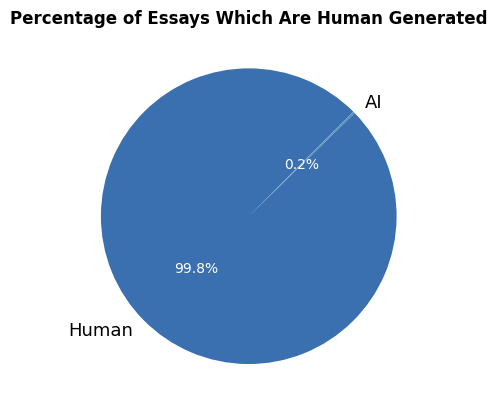

In [ ]:
gen_counts = train_essays["generated"].value_counts()
keys = ["Human", "AI"]

PALETTE = ["#3a6fb0", "#5790c1"]
TEXT_COLOR = "#000000"

wedges, texts, autotexts = plt.pie(gen_counts,
        labels=keys,
        autopct='%.1f%%',
        colors=PALETTE,
        textprops={'color': TEXT_COLOR, 'fontsize': 13},
        pctdistance=0.5,
        startangle=45)

for autotext in autotexts:
  autotext.set_size(10)
  autotext.set_color("#FFFFFF")

plt.title("Percentage of Essays Which Are Human Generated", fontweight="bold");

What about the substance of the human written essays? Below we can see a histogram of the length of each of these essays. The mean length is about 556 words.

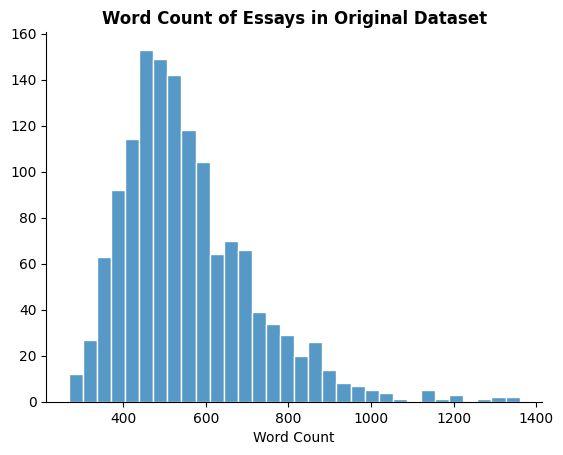

In [ ]:
train_essays["text_length_word"] = train_essays["text"].apply(lambda x : len(x.split()))
g = sns.histplot(train_essays[train_essays.generated == 0],
                 x = "text_length_word",
                 edgecolor="white")

g.set_ylabel('', labelpad=0)
g.set_xlabel("Word Count")
g.set_title("Word Count of Essays in Original Dataset", fontweight="bold");

sns.despine()

In [ ]:
train_essays["text_length_word"].describe()

,text_length_word
count,1378.000000
mean,556.124093
std,159.920005
min,235.000000
25%,447.000000
50%,525.000000
75%,639.000000
max,1360.000000


Let's now look at a more expansive dataset. The [Detect AI Generated Text or DAIGT dataset](https://www.kaggle.com/datasets/thedrcat/daigt-v2-train-dataset) was constructed by the kaggle community to get around the limitations of the original training set. The second version of this set contains the original training examples, the essays of the [persuade corpus](https://www.sciencedirect.com/science/article/pii/S1075293524000588) and additional AI generated essays.

In [3]:
daigt_v2 = pd.read_csv("./drive/My Drive/llm-detect-ai-generated-text/train_v2_drcat_02.csv")

The essays in this dataset are in response to 15 prompts. And we can see that each of them have far more balanced data than the original dataset.

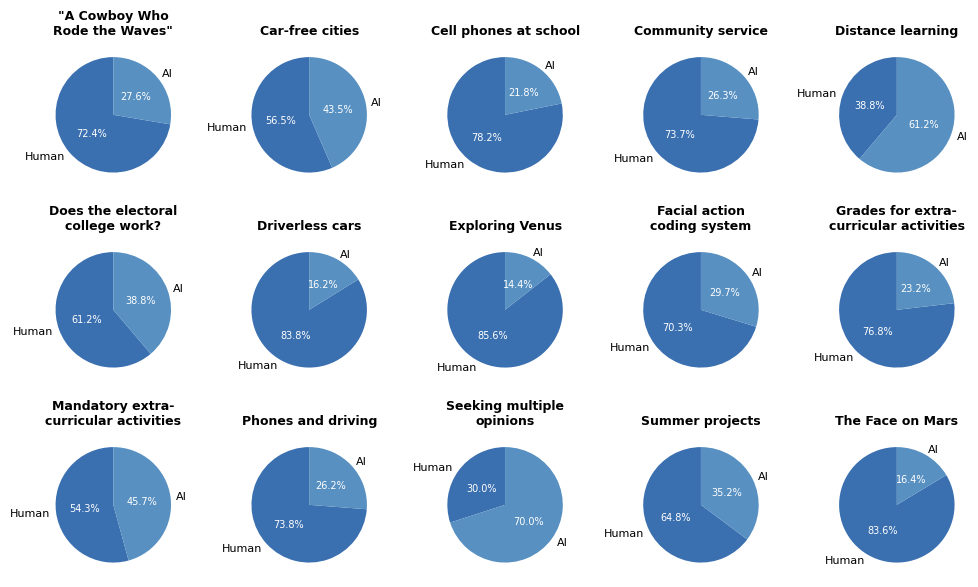

In [ ]:
pie_data = daigt_v2.groupby(["prompt_name", "label"]).size().reset_index()
pie_data["label"] = pie_data["label"].apply(lambda x : "AI" if x else "Human")

pie_data["prompt_name"] = pie_data["prompt_name"].astype("category")
pie_data["prompt_name"] = pie_data["prompt_name"].cat.rename_categories(
    {
        '"A Cowboy Who Rode the Waves"' : '"A Cowboy Who\nRode the Waves"',
        "Does the electoral college work?" : "Does the electoral\ncollege work?",
        "Facial action coding system" : "Facial action\ncoding system",
        "Grades for extracurricular activities" : "Grades for extra-\ncurricular activities",
        "Mandatory extracurricular activities" : "Mandatory extra-\ncurricular activities",
        "Seeking multiple opinions" : "Seeking multiple\nopinions"
    }
)

PALETTE = ["#3a6fb0", "#5790c1"]
TEXT_COLOR = "#000000"

def draw_pie(data, **kwargs):
    wedges, texts, autotexts = plt.pie(data[0],
            labels=data['label'],
            autopct='%1.1f%%',
            colors=PALETTE,
            textprops={'color': TEXT_COLOR, 'fontsize': 8},
            pctdistance=0.5,
            startangle=90)

    for autotext in autotexts:
        autotext.set_size(7)
        autotext.set_color("#FFFFFF")

g = sns.FacetGrid(pie_data, col='prompt_name', col_wrap=5, height=2)
g.map_dataframe(draw_pie)
g.set_titles(
    col_template="{col_name}",
    size = 9,
    fontweight='bold'
    );

The AI generated text comes from a variety of different models

In [ ]:
ai_source = daigt_v2[(daigt_v2.label == 1) & (daigt_v2.source != "train_essays")]
ai_source = ai_source.groupby("source")["text"].count().reset_index()
ai_source["source"] = ai_source["source"].str.replace("mistralai/Mistral-7B-Instruct-v0.1", "Mistral-7B-Instruct-v0.1")
ai_source["source"] = ai_source["source"].str.replace("NousResearch/Llama-2-7b-chat-hf", "Llama-2-7b-chat-hf")
ai_source = ai_source.sort_values('text', ascending=False).reset_index(drop=True)

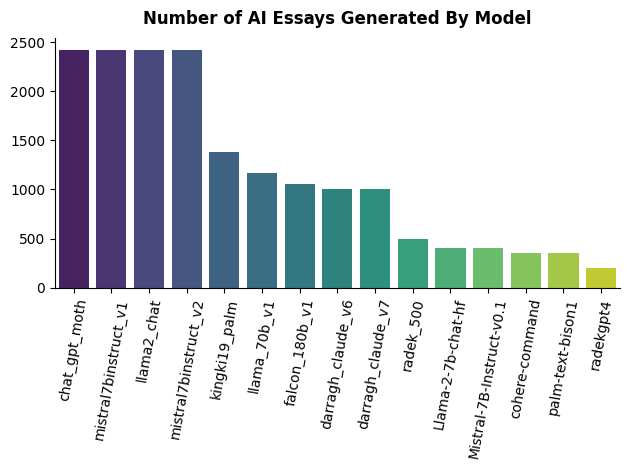

In [ ]:
g = sns.barplot(ai_source, x = "source", y = "text", hue="source", palette='viridis')
g.tick_params(axis='x', labelrotation=80);
g.set_xlabel("")
g.set_ylabel("")
g.set_title("Number of AI Essays Generated By Model", fontweight='bold', pad=10)
sns.despine()
plt.tight_layout()

We can also now take a comparative look at the length of essays written by AI vs humans. We can see clear difference in the distribution of lengths. Whereas the AI essays seem to be clustered mostly in the range of 100-500 words, the human written essays have a much more significant rightward skew. It seems clear that the length of the essay itself contains some information about whether it was written by a human or not.

In [ ]:
word_count = daigt_v2.copy()
word_count["label"] = word_count["label"].apply(lambda x : "AI" if x else "Human")
word_count["word_length"] = word_count["text"].apply(lambda x : len(x.split()))

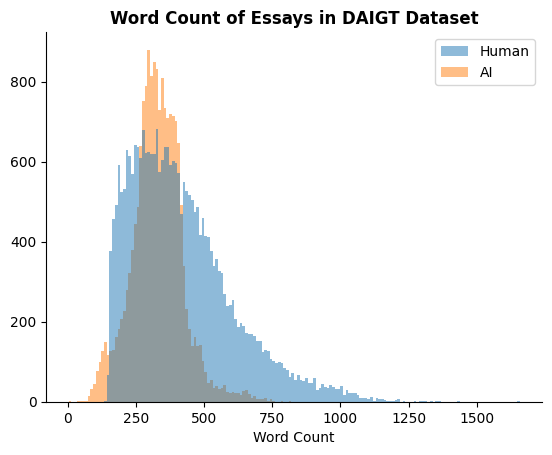

In [ ]:
g = sns.histplot(word_count, x="word_length", hue="label", edgecolor=None)

g.set_ylabel('', labelpad=0)
g.set_xlabel("Word Count")
g.set_title("Word Count of Essays in DAIGT Dataset", fontweight="bold")
g.get_legend().set_title("")

sns.despine()

# Using TF-IDF and Logistic Regression

We'll train our first model by first vectorizing the text using Scikit-learn's TF-IDF Vectorizor and then feeding the vectors into a logistic regression classifier. Using the UMAP (Uniform Manifold Approximation and Projection for Dimension Reduction) dimensionality reduction algorithm, we can see how the different essays are clustered when embedded in TF-IDF Vectors

In [ ]:
reduced = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('umap', UMAP(n_components=2))
])

output = reduced.fit_transform(daigt_v2["text"])

In [ ]:
df = pd.concat([
    pd.DataFrame(output, columns = ["D1", "D2"]),
    daigt_v2[["label", "prompt_name"]],
    axis=1
])
df["label"] = df["label"].apply(lambda x: "AI" if x else "Human")

We can see that TF-IDF does seem to cluster the essays into groups which separate AI generated text from human written text. Still there is some signficant overlap in some areas.

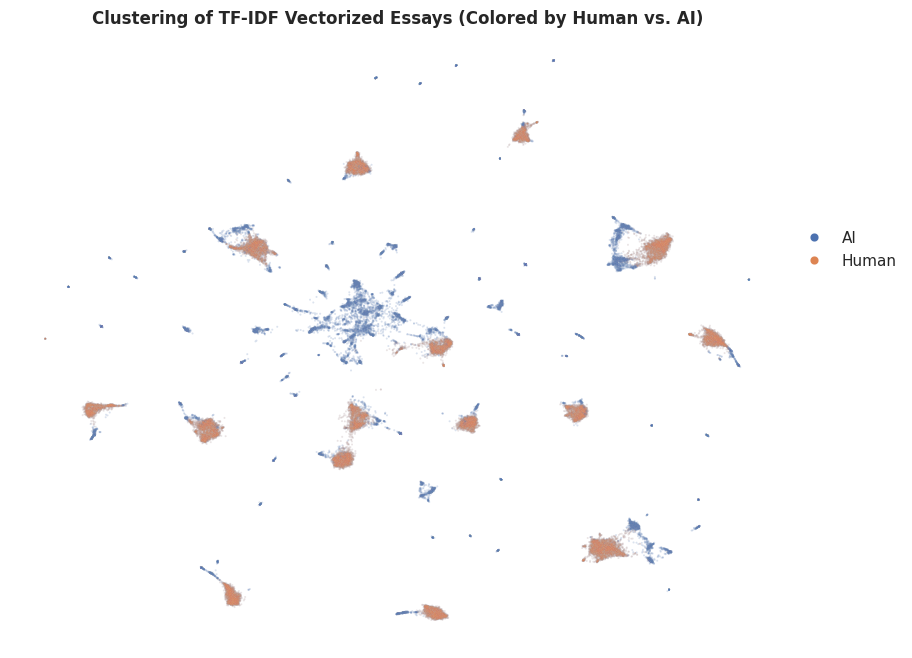

In [ ]:
sns.set_theme(style="white")
plt.figure(figsize=(10, 8))
ax = sns.scatterplot(data=df, x="D1", y="D2", hue="label", s=2, alpha=0.1)
ax.get_legend().set_title("")

ax.axis('off')
ax.set_title("Clustering of TF-IDF Vectorized Essays (Colored by Human vs AI)", fontweight="bold")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.7))
sns.despine()

legend = ax.get_legend()
legend.set_frame_on(False)

for lh in legend.legend_handles:
    lh.set_alpha(1)
    lh.set_markersize(6)

Similarly we can see that TF-IDF embeddings form different clusters for different prompt topics. Unsurprising given that essays on similar prompts will have similar distributions of word frequency.

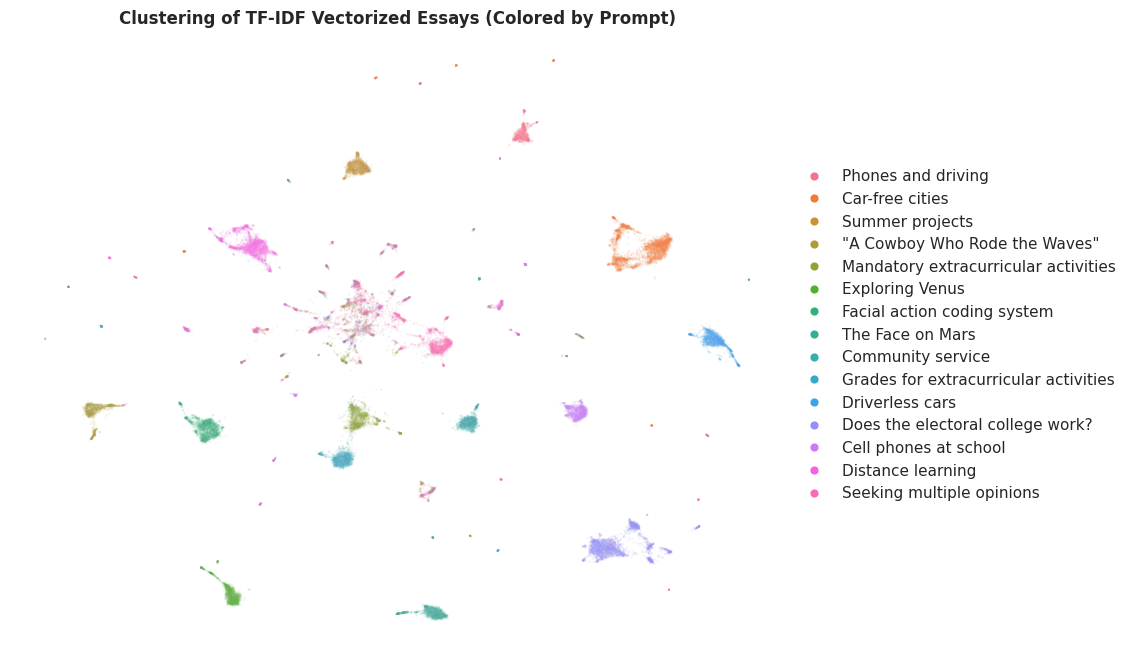

In [ ]:
sns.set_theme(style="white")
plt.figure(figsize=(10, 8))
ax = sns.scatterplot(data=df, x="D1", y="D2", hue="prompt_name", s=2, alpha = 0.1)
ax.get_legend().set_title("")

ax.axis('off')
plt.legend(markerscale=5)
ax.set_title("Clustering of TF-IDF Vectorized Essays (Colored by Prompt)", fontweight="bold")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.8))
sns.despine()

legend = ax.get_legend()
legend.set_frame_on(False)

for lh in legend.legend_handles:
    lh.set_alpha(1)
    lh.set_markersize(6)

This classifier already gives us a reasonably high

In [ ]:
baseline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

splitter = StratifiedKFold(5, shuffle=True, random_state=0)

scores = cross_validate(baseline,
                        daigt_v2["text"],
                        daigt_v2["label"],
                        cv=splitter,
                        scoring=["accuracy",
                                 "f1",
                                 "recall",
                                 "precision",
                                 "roc_auc",
                                 "average_precision"])

summary = {key : [float(np.mean(value))] for key, value in scores.items()}
pd.DataFrame(summary)

,fit_time,score_time,test_accuracy,test_f1,test_recall,test_precision,test_roc_auc,test_average_precision
0,15.54591,6.1877,0.990617,0.987883,0.980854,0.995015,0.998975,0.998818


# DeBERTa and Contrast Learning

We can do better than. The DeBERTa model is a powerful transformer model that can be used to vectorize text. Unlike the TF-IDF vectorization, we can train this model to separate our classes through contrast learning. We start by generating positive and negative pairs which will be used to demonstrate to the model how Human and AI text are different from each other.

In [101]:
train, test = train_test_split(daigt_v2, stratify=daigt_v2.label, test_size=0.1, random_state=random_seed)

In [4]:
import random
from datasets import Dataset

def create_pairs(df, num_pairs=10000):
    pos_pairs, neg_pairs = [], []
    label_groups = df.groupby("label")

    for _ in range(num_pairs):
        # Positive pair
        label = random.choice([0, 1])
        group = label_groups.get_group(label).sample(2)
        text1 = group.iloc[0]["text"]
        text2 = group.iloc[1]["text"]
        pos_pairs.append({
            "sentence1" : text1,
            "sentence2" : text2,
            "label": 1
        })

        # Negative pair
        text1 = label_groups.get_group(0).sample(1).iloc[0]["text"]
        text2 = label_groups.get_group(1).sample(1).iloc[0]["text"]
        neg_pairs.append({
            "sentence1" : text1,
            "sentence2" : text2,
            "label": 0
        })

    return pos_pairs + neg_pairs

train_pairs = create_pairs(train, num_pairs=10000)
test_pairs = create_pairs(test, num_pairs=2000)

train_ds = Dataset.from_list(train_pairs)
test_ds = Dataset.from_list(test_pairs)

In [ ]:
import torch
torch.cuda.empty_cache()

model = SentenceTransformer('embedding-data/deberta-sentence-transformer')

evaluator = EmbeddingSimilarityEvaluator(
  sentences1=test_ds["sentence1"],
  sentences2=test_ds["sentence2"],
  scores=test_ds["label"],
  main_similarity="cosine"
)

train_loss = losses.CosineSimilarityLoss(model=model)

args = SentenceTransformerTrainingArguments(
  output_dir="./drive/My Drive/llm-detect-ai-generated-text/cosineloss_embedding_model",
  num_train_epochs=1,
  per_device_train_batch_size=8,
  per_device_eval_batch_size=8,
  warmup_steps=200,
  fp16=False,
  eval_steps=250,
  logging_steps=250,
  save_strategy="steps",
  save_steps=250,
  report_to="wandb"
)

trainer = SentenceTransformerTrainer(
  model=model,
  args=args,
  train_dataset=train_ds,
  loss=train_loss,
  evaluator=evaluator
)

trainer.train()
evaluator(model)

In [ ]:
model = SentenceTransformer("./drive/My Drive/llm-detect-ai-generated-text/cosineloss_embedding_model/checkpoint-2500")
embeddings = model.encode(daigt_v2["text"], show_progress_bar=True)

In [74]:
dim_reducer = UMAP(n_components=2)
reduced = dim_reducer.fit_transform(embeddings)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [82]:
df = pd.concat([
    pd.DataFrame(reduced, columns = ["D1", "D2"]),
    daigt_v2[["label", "prompt_name", "source"]]
])
df["label"] = df["label"].apply(lambda x: "AI" if x else "Human")

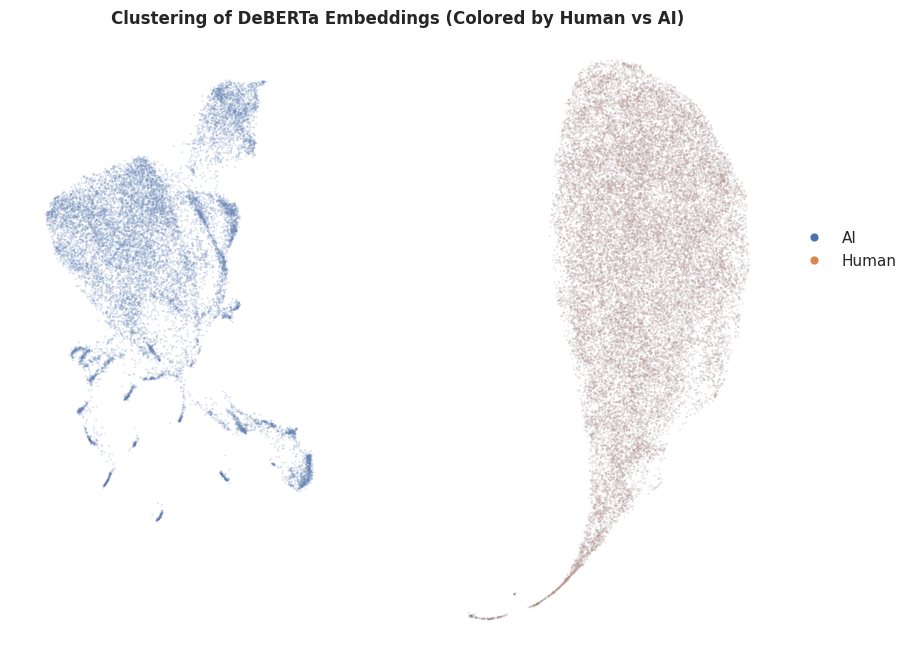

In [83]:
sns.set_theme(style="white")
plt.figure(figsize=(10, 8))
ax = sns.scatterplot(data=df, x="D1", y="D2", hue="label", s=2, alpha=0.1)
ax.get_legend().set_title("")

ax.axis('off')
ax.set_title("Clustering of DeBERTa Embeddings (Colored by Human vs AI)", fontweight="bold")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.7))
sns.despine()

legend = ax.get_legend()
legend.set_frame_on(False)

for lh in legend.legend_handles:
    lh.set_alpha(1)
    lh.set_markersize(6)

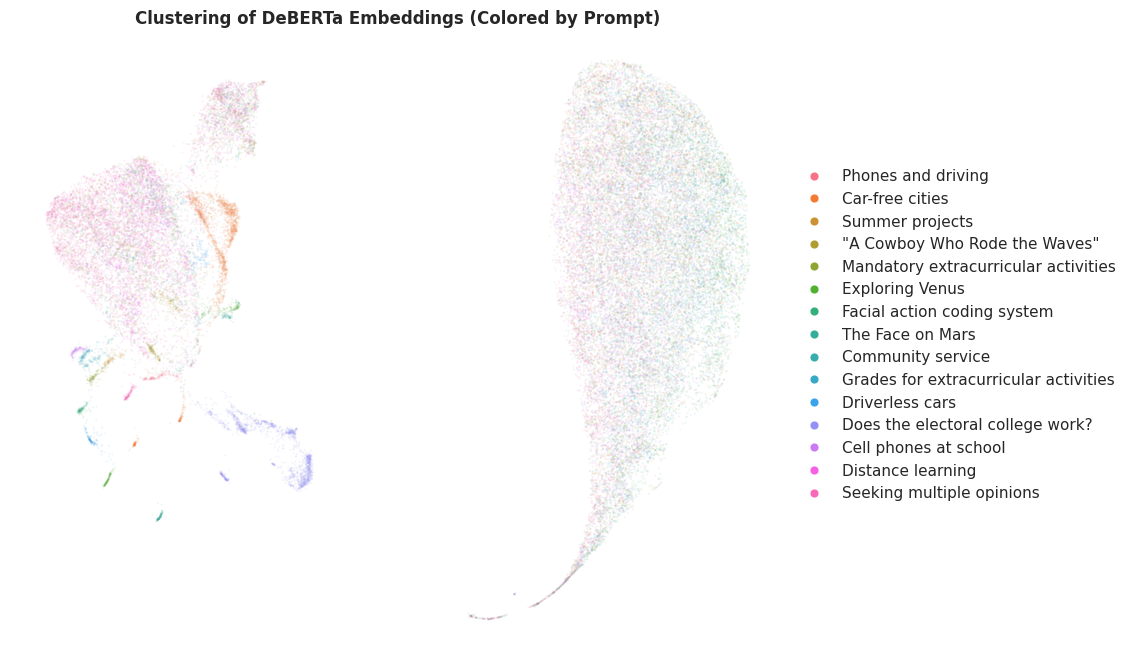

In [91]:
sns.set_theme(style="white")
plt.figure(figsize=(10, 8))
ax = sns.scatterplot(data=df, x="D1", y="D2", hue="prompt_name", s=2, alpha = 0.1)
ax.get_legend().set_title("")

ax.axis('off')
plt.legend(markerscale=5)
ax.set_title("Clustering of DeBERTa Embeddings (Colored by Prompt)", fontweight="bold")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.8))
sns.despine()

legend = ax.get_legend()
legend.set_frame_on(False)

for lh in legend.legend_handles:
    lh.set_alpha(1)
    lh.set_markersize(6)

In [108]:
clf = LogisticRegression(max_iter=1000)

X_train = embeddings[train.index]
X_test = embeddings[test.index]
y_train = train["label"]
y_test = test["label"]

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Human", "AI"], digits=4))

              precision    recall  f1-score   support

       Human     0.9971    0.9989    0.9980      2737
          AI     0.9983    0.9954    0.9969      1750

    accuracy                         0.9975      4487
   macro avg     0.9977    0.9972    0.9974      4487
weighted avg     0.9975    0.9975    0.9975      4487

